# MI German

In [153]:
import mne
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew , variation
from scipy.signal import welch
%matplotlib ipympl 

In [252]:
#пусть данные хранятся по папкам с именем пациента и названием эксперимента
print('Patient name')
patient = input()
print('Experiment Type')
exp_type = input()
print('VHDR file location')
filename = input()
print(patient, exp_type, filename)
folder = patient +'_'+exp_type
!mkdir folder

Patient name
German
Experiment Type
MI
VHDR file location
../eeg/german/mi01/NeoRec_2022-03-18_17-51-00.vhdr
German MI ../eeg/german/mi01/NeoRec_2022-03-18_17-51-00.vhdr


In [181]:
raw = mne.io.read_raw_brainvision('../eeg/german/mi01/NeoRec_2022-03-18_17-51-00.vhdr', preload = True )
raw.set_channel_types({'Left':'emg', 'Right': 'emg'})
raw.set_eeg_reference(['A1','A2'])
raw.set_montage('standard_1020')

Extracting parameters from ../eeg/german/mi01/NeoRec_2022-03-18_17-51-00.vhdr...
Setting channel info structure...
Reading 0 ... 236310  =      0.000 ...   236.310 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawBrainVision | NeoRec_2022-03-18_17-51-00.eeg, 26 x 236311 (236.3 s), ~46.9 MB, data loaded>

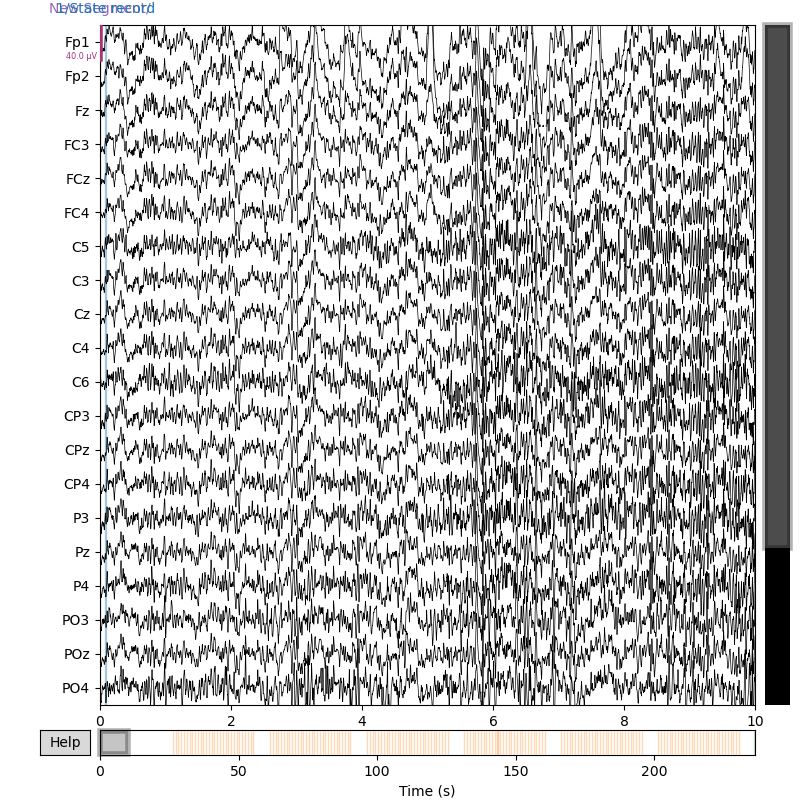

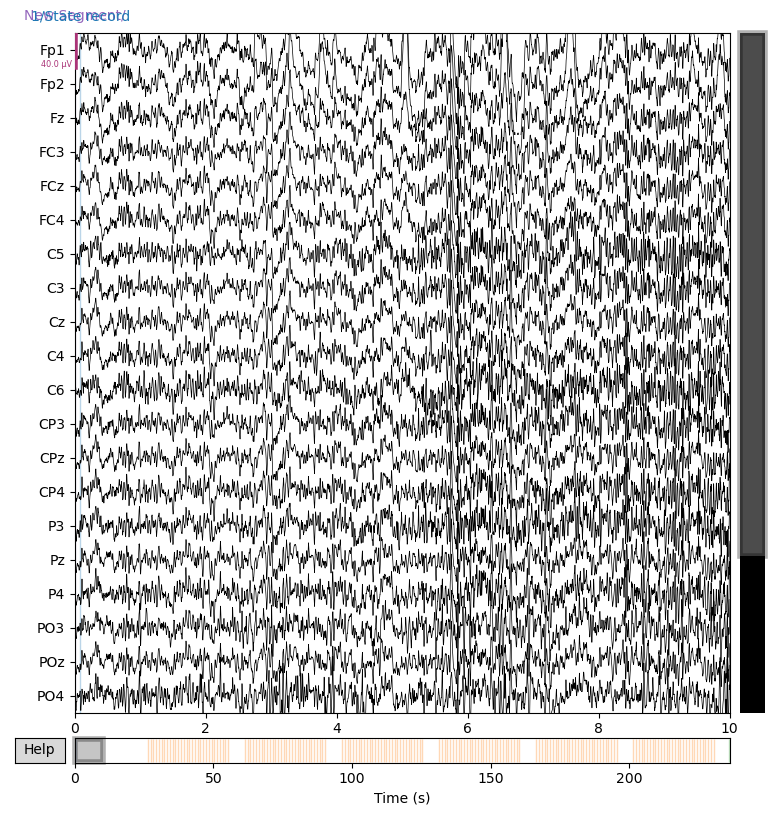

In [201]:
raw.plot()

In [182]:
events, event_id = mne.events_from_annotations(raw)
metas = np.load('meta/German_MI.npy')
meta = (metas == 'Right')#Right - true, left - false
mask = np.tile(meta, (1,30))
events[2:-1][:,2] = events[2:-1][:,2]*mask
events = mne.pick_events(events, include = [10002, 0])
event_id = { 'right':10002, 'left':0}

Used Annotations descriptions: ['1/State record', '13/In\\ 7', '2/State stop', 'New Segment/']


# Preprocessing



In [192]:
raw_f = raw.copy().filter(1,None)
raw_f = raw_f.notch_filter((50,100,150,200))

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)



Effective window size : 2.048 (s)


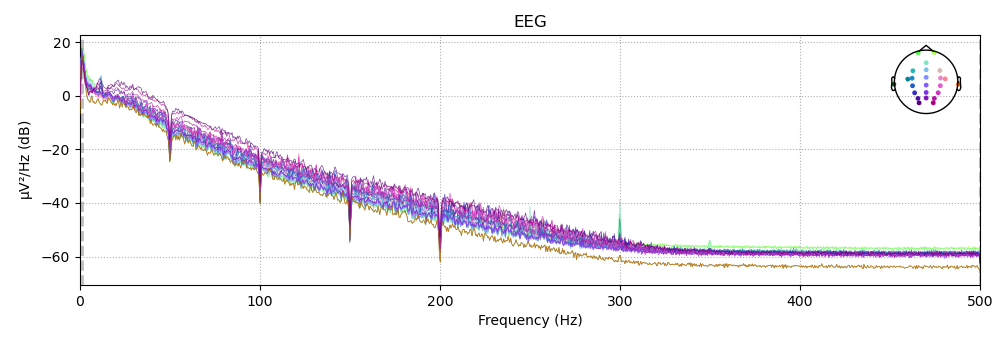

In [200]:
raw_f.plot_psd();

Fitting ICA to data using 24 channels (please be patient, this may take a while)
Selecting by explained variance: 10 components
Fitting ICA took 1.9s.


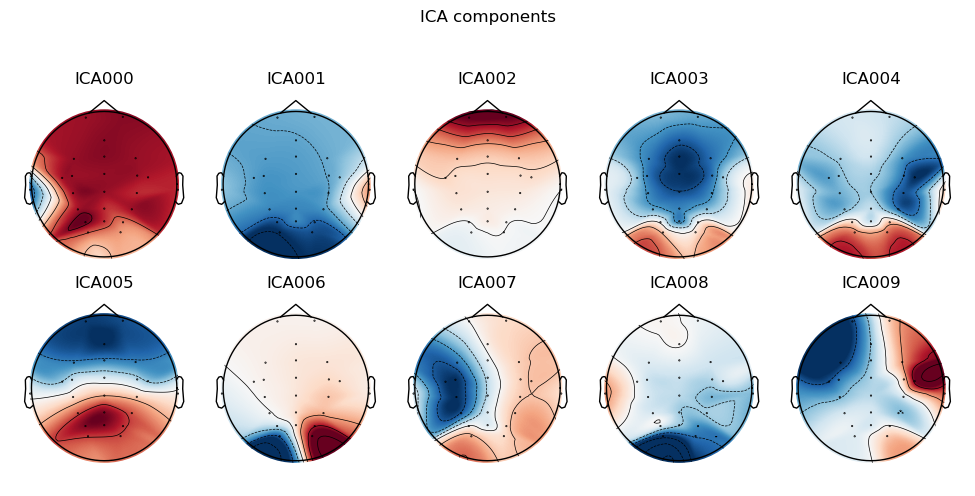

[<MNEFigure size 975x496 with 10 Axes>]

In [221]:
ica = mne.preprocessing.ICA(0.99)
ica.fit(raw_f)
ica.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
118 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


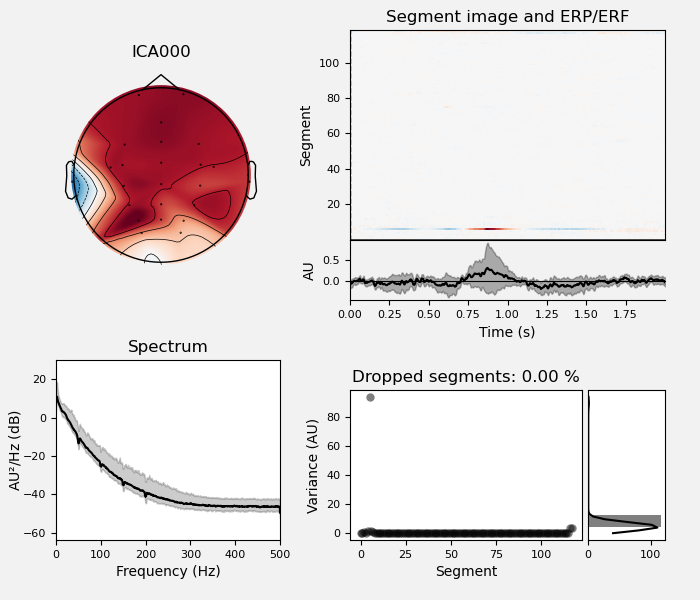

[<Figure size 700x600 with 6 Axes>]

In [216]:
ica.plot_properties(raw_f,picks=[0])

In [222]:
ica.exclude=[2]

Creating RawArray with float64 data, n_channels=10, n_times=236311
    Range : 0 ... 236310 =      0.000 ...   236.310 secs
Ready.


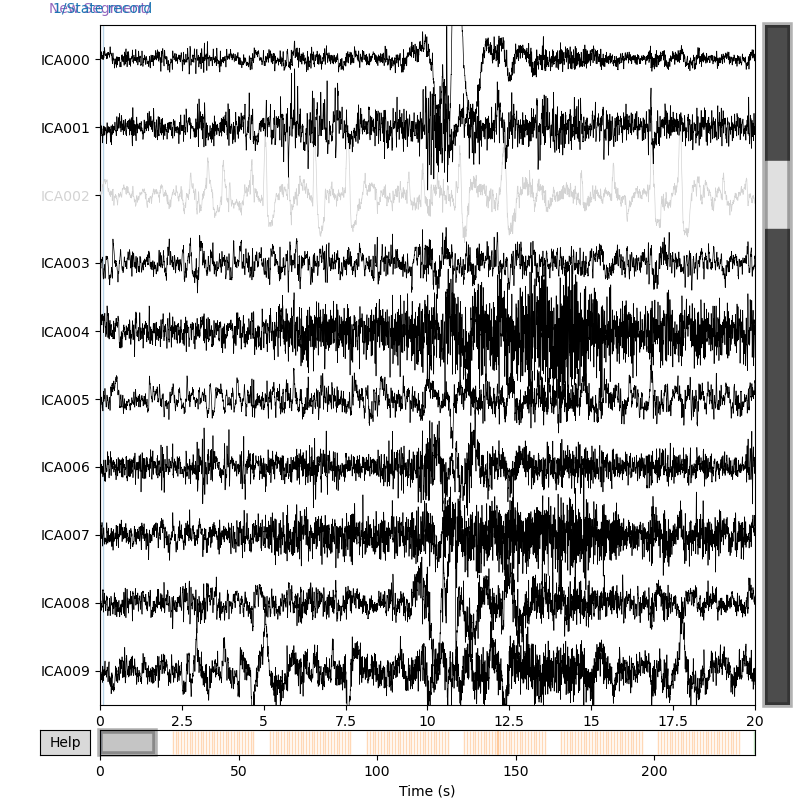

In [232]:
ica.plot_sources(raw_f, show_scrollbars=True);

In [227]:
raw_orig = raw.copy()
ica.apply(raw)
raw.filter(l_freq = 1, h_freq=30)

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 1 ICA component
    Projecting back using 24 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 sec)



<RawBrainVision | NeoRec_2022-03-18_17-51-00.eeg, 26 x 236311 (236.3 s), ~46.9 MB, data loaded>

# Epoching

In [228]:
epochs = mne.Epochs(raw, events, event_id = event_id, tmin = -0.3, tmax =0.6,baseline=(None,None),preload=True)

Not setting metadata
Not setting metadata
180 matching events found
Setting baseline interval to [-0.3, 0.6] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 180 events and 901 original time points ...
0 bad epochs dropped


In [253]:
epochs.save(folder+folder+'-epo.fif',overwrite=True)

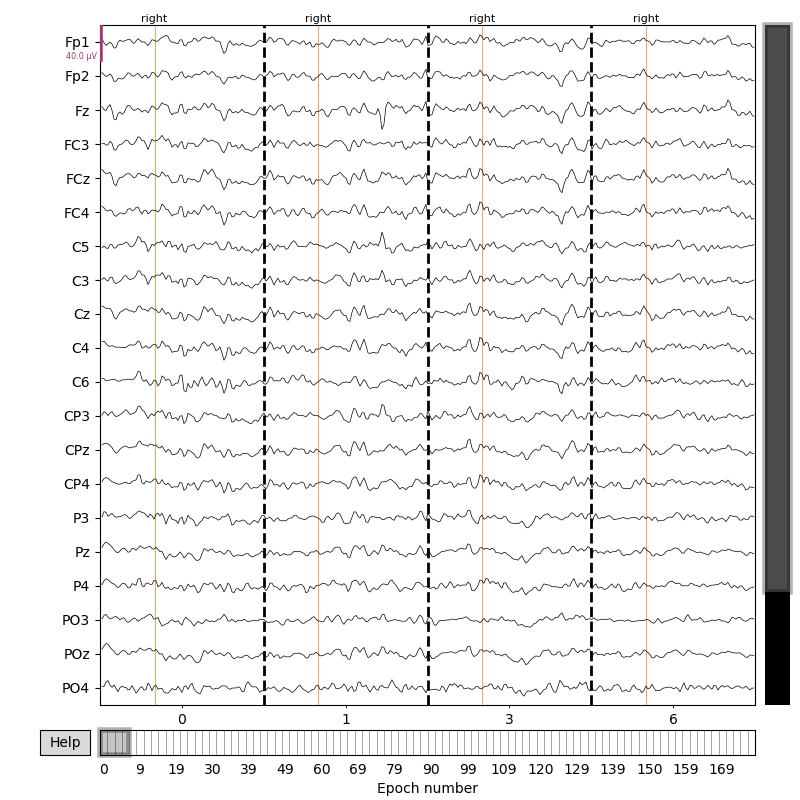

In [229]:
epochs['right'].plot(events=events, event_id=event_id,n_epochs =4);

# Desynchronization

let`s compare psd before and after stimuli.

In [260]:
epochs_b = epochs.copy().crop(-0.3,0)#before
epochs_a = epochs.copy().crop(0,0.6)#after

    Using multitaper spectrum estimation with 7 DPSS windows


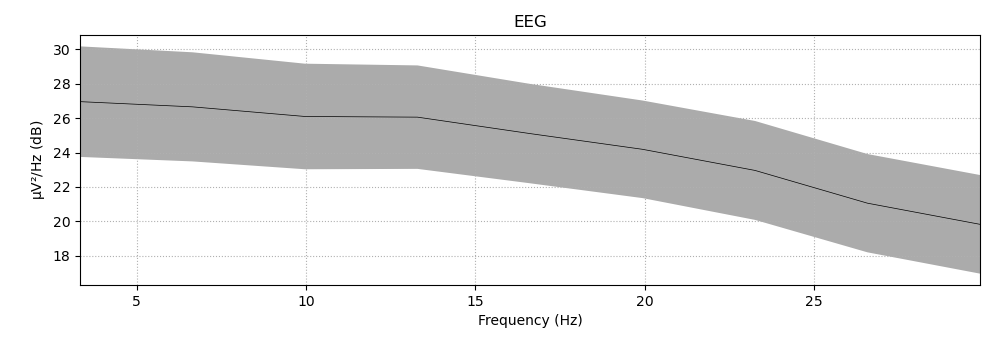

    Using multitaper spectrum estimation with 7 DPSS windows


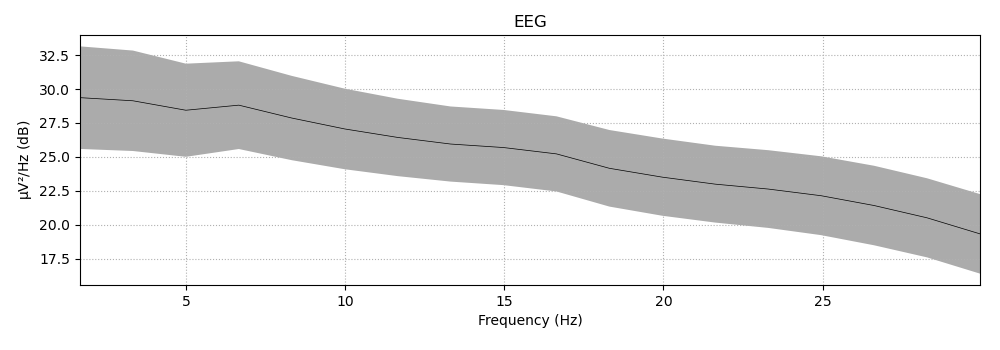

In [261]:
epochs_b['right'].plot_psd(fmin=1, fmax=30,average=True, picks='eeg');
epochs_a['right'].plot_psd(fmin=1, fmax=30,average=True,picks='eeg');

    Using multitaper spectrum estimation with 7 DPSS windows


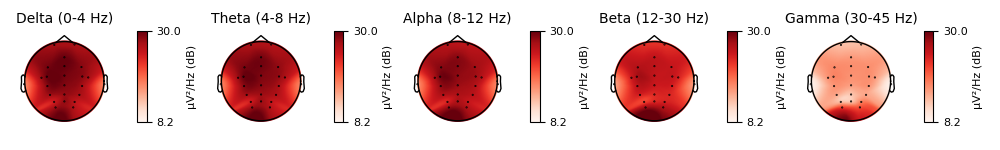

    Using multitaper spectrum estimation with 7 DPSS windows


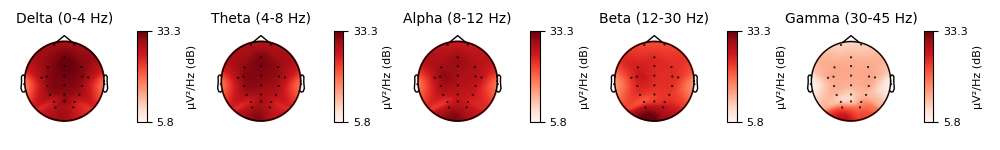

In [266]:
epochs_b['right'].plot_psd_topomap(vlim='joint');
epochs_a['right'].plot_psd_topomap(vlim='joint');

# Average of epochs and evoked

Not setting metadata
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


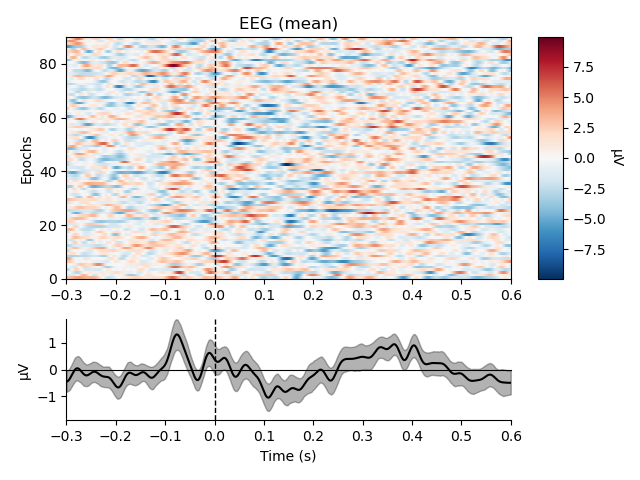

[<Figure size 640x480 with 3 Axes>]

In [268]:
epochs['right'].plot_image(picks='eeg', combine='mean')#ПОХОЖЕ НА P300

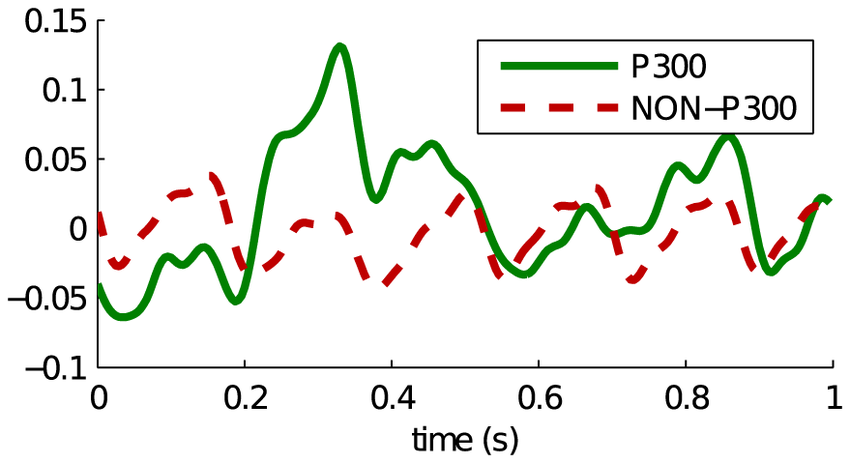